In [1]:
import sys
import xarray as xr
import numpy as np
import Plotter
from Plotter import Plotter
import time
from preprocessing_utils import *
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import metrics
import pyxpcm
from pyxpcm.models import pcm
import warnings
import glob
import seaborn as sns
from joblib import dump, load

from joblib import Parallel, delayed
import multiprocessing

warnings.filterwarnings('ignore')

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
def score_model(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    print("sample")
    print(f"model score (higher is best): {m.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, pred)}")
    print("---------------------------------------------------")
    print("full")
    print(f"model score (higher is best): {m_full.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, truth)}")
    print("---------------------------------------------------")
    print(f" adjusted rand score: {metrics.adjusted_rand_score(truth, pred)}")
    print(f" unadjusted rand score: {metrics.rand_score(truth, pred)}")
    print("---------------------------------------------------")
    print(f" adjusted mutual info score: {metrics.adjusted_mutual_info_score(truth, pred)}")
    print(f" unadjusted mutual info score: {metrics.mutual_info_score(truth, pred)}")

#     print(f"model score: {m.score(x)}")
#     print(f"model score: {m.score(x)}")

In [4]:
def score_iter(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    return m.score(x), metrics.rand_score(truth, pred), metrics.mutual_info_score(truth, pred)

In [5]:
def predict(x, m, var_name_ds, k, var_predict):
    classif = m.predict(x[var_predict])
    return classif

In [6]:
def assign_pred(x, classif, k, var_name_ds):
    x = x.assign(variables={"labels": ('sample_dim', classif)})
    q = [0.05, 0.5, 0.95]
    x = compute_quantile(x, var_name_ds, k, q)
    x = x.assign_coords(coords={'k': range(k)})
    x = x.unstack('sample_dim')
    return x

In [7]:
def generate_plots(ds, var_name_ds, k, algorithm):
    """
    Generates and saves the following plots:
    - vertical structure: vertical structure of each classes. It draws the mean profile and the 0.05 and 0.95 quantiles
    - vertical structure comp: vertical structure graph but Quantiles are being plotted together to highlight
    differences between classes.
    - Spacial distribution: plot the PCM labels in a map to analyse the spatial coherence of classes.
    - Robustness: spacial distribution of a scaled probability of a profile to belong to a class.
    - Pie chart: pie chart showing the percentage of profiles belonging to each class and the number of
    classified profiles.
    - Temporal distribution by month: The bar plots represents the percentage of profiles in each class by month.
    - Temporal distribution by season: The bar plots represents the percentage of profiles in each class by season.
    Parameters
    ----------
    ds : Xarray dataset containing the predictions
    var_name_ds : name of the variable in the dataset

    Returns
    -------
    saves all the plots as png
    """
    try:
        x_label = ds[var_name_ds].attrs['long_name'] + " in " + ds[var_name_ds].attrs['unit_long']
    except KeyError:
        x_label = var_name_ds

    # create a pyXpcm model to use the Plotter class
    var_name_mdl = var_name_ds
    z_dim = 'depth'
    z = ds[z_dim]
    pcm_features = {var_name_mdl: z}
    m = pcm(K=k, features=pcm_features)
    ds = ds.rename({'labels': 'PCM_LABELS'})
    ds = ds.sortby('latitude').sortby('longitude')
    P = Plotter(ds, m, coords_dict={'latitude': 'latitude', 'longitude': 'longitude', 'time': 'time', 'depth': 'depth'})

    # plot profiles by class
    P.vertical_structure(q_variable=var_name_ds + '_Q', sharey=True, xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc{algorithm}.png')
    # plot profiles by quantile
    P.vertical_structure_comp(q_variable=var_name_ds + '_Q', plot_q='all', xlabel=x_label)
#     P.save_BlueCloud(f'./GMM_scaling_out/vertical_struc_comp{algorithm}.png')
    # spacial distribution
#     P.spatial_distribution(time_slice='most_freq_label')
#     P.save_BlueCloud(f'./GMM_scaling_out/spatial_distr_freq{algorithm}.png')
    for i in range(1,10):
        P.spatial_distribution(time_slice='2018-0' + str(i))
    for i in range(10,13):
        P.spatial_distribution(time_slice='2018-' + str(i))
    # robustness
    # P.plot_robustness(time_slice=first_date)
    # P.save_BlueCloud('robustness.png')
    # pie chart of the classes distribution
    P.pie_classes()
#     P.save_BlueCloud(f'./GMM_scaling_out/pie_chart{algorithm}.png')
    # temporal distribution (monthly)
    try:
        P.temporal_distribution(time_bins='month')
#         P.save_BlueCloud('temporal_distr_months.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_months')
        print('plot monthly temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)
    # temporal distribution (seasonally)
    try:
        P.temporal_distribution(time_bins='season')
#         P.save_BlueCloud('temporal_distr_season.png')
    except (ValueError, AssertionError) as e:
#         save_empty_plot('temporal_distr_season')
        print('plot seasonal temporal distribution is not available, the following error occurred:')
        print(e, file=sys.stderr)

# Execution of the code

## parameters

In [8]:
# var_name_ds = "TEMP"
var_name_ds = 'thetao'
var_name_mdl = "temperature"
# algorithm choice can be: "kmean" for classic sklarn kmean, "batch" for sklearn kmean mini-batch, "GMM" for sklearn GMM
algorithm = "GMM"
k = 6
# file_name = '../datasets/global-reanalysis-phy-001-030-monthly_big.nc'
# dir_path = '/home/ref-coriolis-public/copernicus/INSITU_GLO_TS_OA_REP_OBSERVATIONS_013_002_b/CORIOLIS-GLOBAL-CORA-OBS_FULL_TIME_SERIE/field/'
# file_list = glob.glob(f"{dir_path}2019/*TEMP.nc")
# file_list+=glob.glob(f"{dir_path}2018/*TEMP.nc")

dir_path = "../datasets/"
file_list = glob.glob(f"{dir_path}global-reanalysis-phy-001-030-monthly_big.nc")
print(len(file_list))

len(file_list)
# spacial_domain = {"lon":[-5, 42],
#                  "lat": [30, 46],
#                  "depth": 800}
spacial_domain = {"lon":[-80, 80],
                 "lat": [-80, 80],
                 "depth": 800}
spacial_domain

1


{'lon': [-80, 80], 'lat': [-80, 80], 'depth': 800}

## Load and preprocessing
see in file preprocessing utils for details

In [12]:
x = preprocessing_allin(path=file_list, scaling=True, multiple=True, backend='sk', 
                        var_name=var_name_ds, n_comp_pca=15, spacial_domain=spacial_domain)
x

size full DS: 1.303983673453331 Go
size after selection of variable: 1.303983673453331 Go


<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 15, sample_dim: 3466693)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * sample_dim             (sample_dim) MultiIndex
  - longitude              (sample_dim) float64 -5.0 -5.0 -5.0 ... 41.5 41.5
  - latitude               (sample_dim) float64 35.75 35.75 ... 41.83 41.83
  - time                   (sample_dim) datetime64[ns] 2010-08-16T12:00:00 .....
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (sample_dim, depth) float32 25.16 25.02 ... 8.815
    thetao_scaled          (sample_dim, feature) float32 1.066 1.055 ... -2.255
    thetao_scaled_reduced  (sample_dim, feature_reduced) float32 -2.758 ... -...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Training

In [13]:
var_train = var_name_ds + "_scaled_reduced"

In [14]:
%%time
# m_full = train_model(k=k, x=x[var_train], algo=algorithm)
m_full = load('modelk6_full_10y.joblib')

CPU times: user 758 µs, sys: 212 µs, total: 970 µs
Wall time: 942 µs


In [15]:
# dump(m_full, 'modelk6_full_10y.joblib') 

In [16]:
m_full.score(x[var_train])

20.165304411520065

## subsampling for training

In [17]:
# training m model for predictions

score = -np.infty
max_lower_bound = -np.infty
avg_score = 0
samples = 10_000
start_time = time.time()
for i in range(10):
    index_train = np.random.choice(len(x[var_train]), samples)
    m_i = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-8, n_init=1)
    m_i.fit(x[var_train][index_train])
    score_i = m_i.score(x[var_train])
    avg_score += score_i
    if score_i>score:
#     if max_lower_bound < m_i.lower_bound_:
        max_lower_bound = m_i.lower_bound_
        score = score_i
        m = m_i
        best_iter = i
exec_time_i = time.time()-start_time
print(f"\t training finished in {exec_time_i}s")
score_sample = m.score(x[var_train])
print(f"\t number of samples train: {samples}\n\t score: {score_sample}")
print(f"\t best iter: {best_iter}\n\t avg score: {avg_score/10}")

	 training finished in 69.53744316101074s
	 number of samples train: 10000
	 score: 20.096517451059363
	 best iter: 0
	 avg score: 20.06110325684105


In [18]:
# ------------ long loops for full traing curves -------------- #


# %%time
# import pandas as pd

# save_results = []
# save_best_iter = []
# save_time = []
# save_avg = []
# test_list = [100, 1_000, 2_500, 5_000, 10_000, 25_000, 50_000, 100_000]
# run_results = []
# idx_exec = 1
# for test_run in range(5):
#     print("test run nb: ", test_run)
#     for samples in test_list:
#         print(f"\t number of samples train: {samples}\n\t training starting...")
#         score = -np.infty
#         max_lower_bound = -np.infty
#         avg_score = 0
#         start_time = time.time()
#         for i in range(10):
#             index_train = np.random.choice(len(x[var_train]), samples)
#             m_i = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-8, n_init=1)
#             m_i.fit(x[var_train][index_train])
#             score_i = m_i.score(x[var_train])
#             avg_score += score_i
#             if score_i>score:
#         #     if max_lower_bound < m_i.lower_bound_:
#                 max_lower_bound = m_i.lower_bound_
#                 score = score_i
#                 m = m_i
#                 best_iter = i
#         exec_time_i = time.time()-start_time
#         print(f"\t training finished in {exec_time_i}s")
#         score_sample = m.score(x[var_train])
#         print(f"\t number of samples train: {samples}\n\t score: {score_sample}")
#         print("------------------------------------------------------")
#         row = {
#             'id': idx_exec,
#             'sample_size': samples,
#             'saved_model_score': score_sample,
#             'best_iter': best_iter,
#             'time': exec_time_i,
#             'avg': avg_score/10
#         }
#         if idx_exec == 1:
#             pd.DataFrame([row]).to_csv('exec_log.csv')
#         else:
#             pd.DataFrame([row]).to_csv('exec_log.csv', mode='a', header=False)
#         idx_exec += 1

In [19]:
score_model(m=m, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 20.096517451059363
---------------------------------------------------
full
model score (higher is best): 20.165304411520065
---------------------------------------------------
 adjusted rand score: 221.51569847581956
 unadjusted rand score: 0.9864089392134577
---------------------------------------------------
 adjusted mutual info score: 0.9471293344280872
 unadjusted mutual info score: 1.5629443341904556


## Prediction and quantile computation

In [20]:
# --------- Assign same cluster id for each method ----------- #
from sklearn.metrics.pairwise import pairwise_distances_argmin

def assign_cluster_number(x):
    if x==x:
        return float(order[int(x)])
    else:
        return x

order = pairwise_distances_argmin(m_full.means_, m.means_)
order

array([0, 4, 2, 1, 5, 3])

In [24]:
%%time
pred = predict(m=m, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)
ds = assign_pred(x=x, classif=pred, k=k, var_name_ds=var_name_ds)
ds

CPU times: user 23.5 s, sys: 6.72 s, total: 30.2 s
Wall time: 8.44 s


<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 15, k: 6, latitude: 184, longitude: 559, quantile: 3, time: 107)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * quantile               (quantile) float64 0.05 0.5 0.95
  * k                      (k) int64 0 1 2 3 4 5
  * longitude              (longitude) float64 -5.0 -4.917 -4.833 ... 41.42 41.5
  * latitude               (latitude) float64 35.75 35.83 35.92 ... 30.83 30.75
  * time                   (time) datetime64[ns] 2010-08-16T12:00:00 ... 2019...
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (depth, longitude, latitude, time) float32 25.16 ....
    thetao_scaled          (feature, longitude, latitude, time) float32 1.066...
    thetao_scaled_reduced  (feature_reduced, longitude, latitude, time) float32 ...
    labels                 (longitude, latitude, time) float64 5.0 5.0 ... nan
    thetao_Q               (k, quantile, depth) float64 15.05 15.04 ... 15.24
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [39]:
%%time
pred_full = predict(m=m_full, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)
print(pred_full)
vfunc = np.vectorize(assign_cluster_number)
pred_full = vfunc(pred_full)
# pred_full = xr.apply_ufunc(assign_cluster_number, xr.DataArray(pred_full), dask="parallelized", vectorize=True)
print(pred_full)
ds_full = assign_pred(x=x, classif=pred_full, k=k, var_name_ds=var_name_ds)
ds_full

[4 4 2 ... 1 1 1]
[5. 5. 2. ... 4. 4. 4.]
CPU times: user 26.3 s, sys: 10.8 s, total: 37.1 s
Wall time: 16.4 s


<xarray.Dataset>
Dimensions:                (depth: 30, feature: 30, feature_reduced: 15, k: 6, latitude: 184, longitude: 559, quantile: 3, time: 107)
Coordinates:
  * depth                  (depth) float32 -0.494 -1.541 ... -318.1 -380.2
  * quantile               (quantile) float64 0.05 0.5 0.95
  * k                      (k) int64 0 1 2 3 4 5
  * longitude              (longitude) float64 -5.0 -4.917 -4.833 ... 41.42 41.5
  * latitude               (latitude) float64 35.75 35.83 35.92 ... 30.83 30.75
  * time                   (time) datetime64[ns] 2010-08-16T12:00:00 ... 2019...
Dimensions without coordinates: feature, feature_reduced
Data variables:
    thetao                 (depth, longitude, latitude, time) float32 25.16 ....
    thetao_scaled          (feature, longitude, latitude, time) float32 1.066...
    thetao_scaled_reduced  (feature_reduced, longitude, latitude, time) float32 ...
    labels                 (longitude, latitude, time) float64 5.0 5.0 ... nan
    thetao_Q               (k, quantile, depth) float64 15.08 15.08 ... 15.24
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Plots

plot finished in 24.0961651802063sec
CPU times: user 13.3 s, sys: 9.17 s, total: 22.5 s
Wall time: 24.1 s


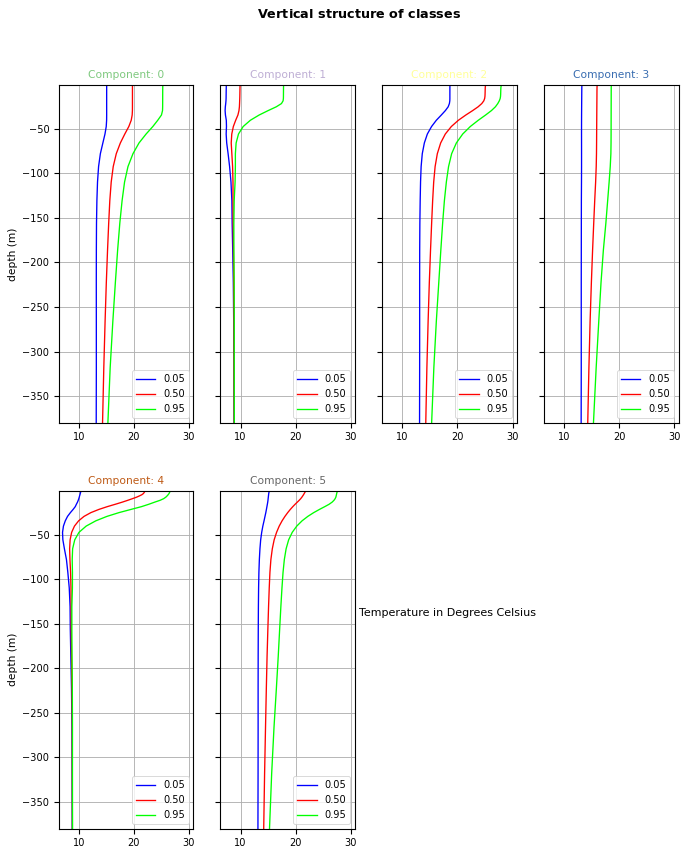

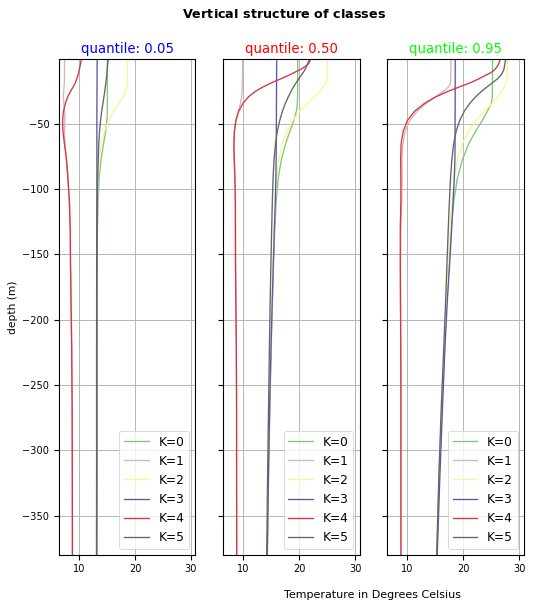

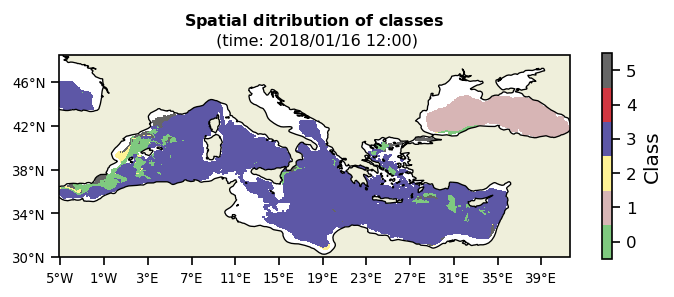

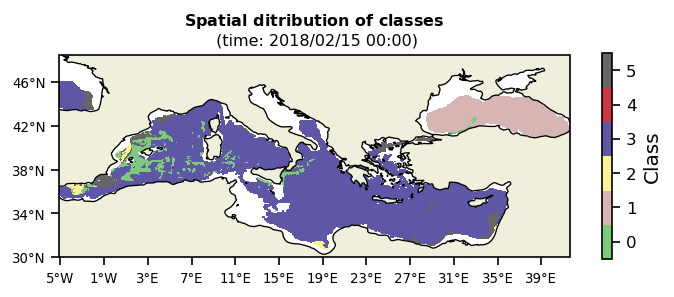

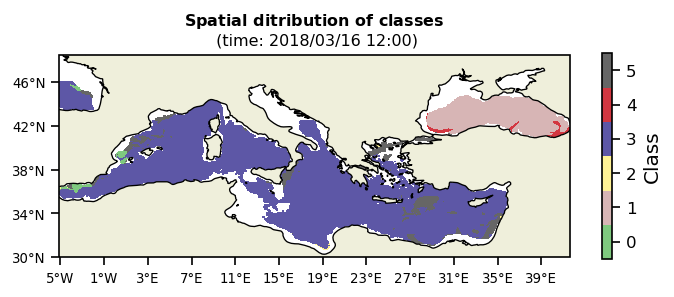

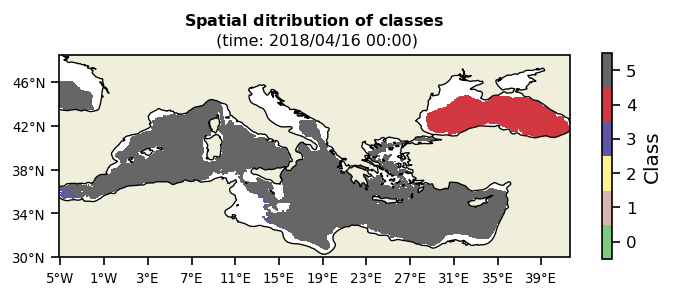

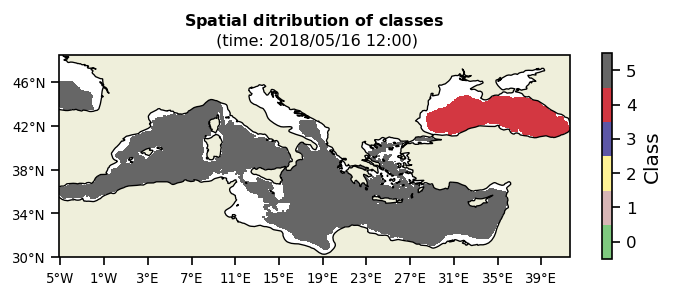

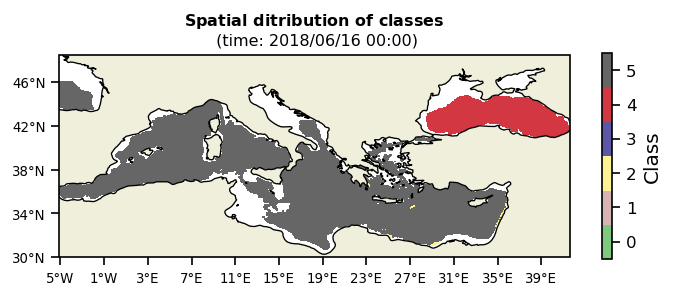

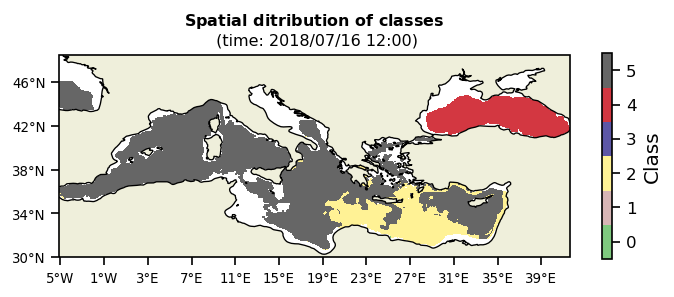

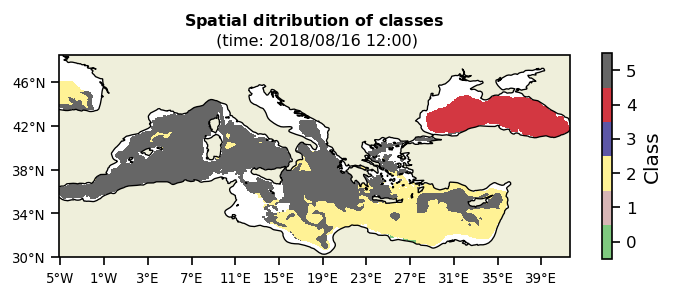

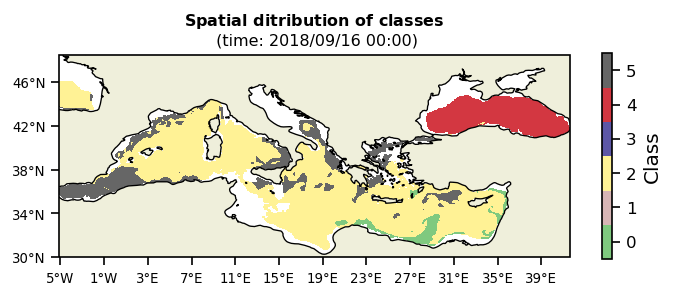

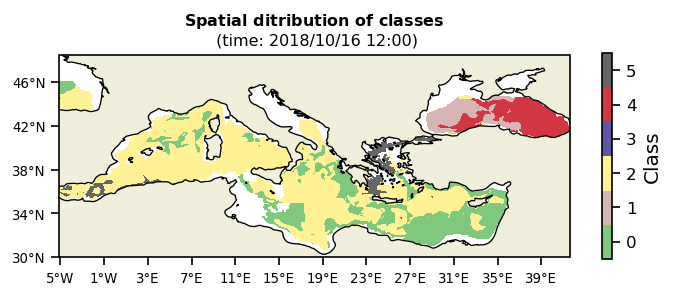

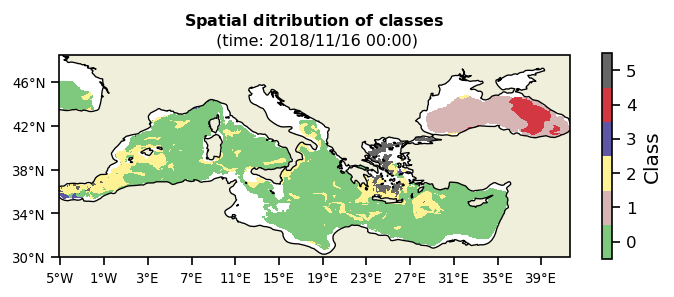

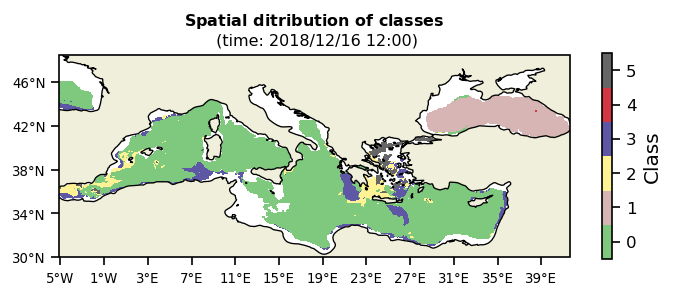

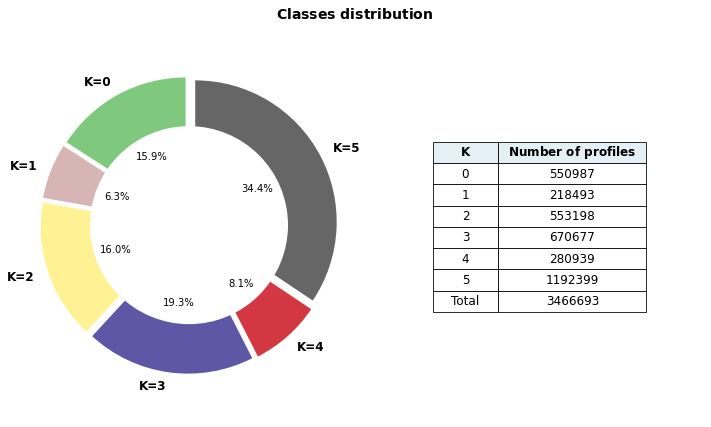

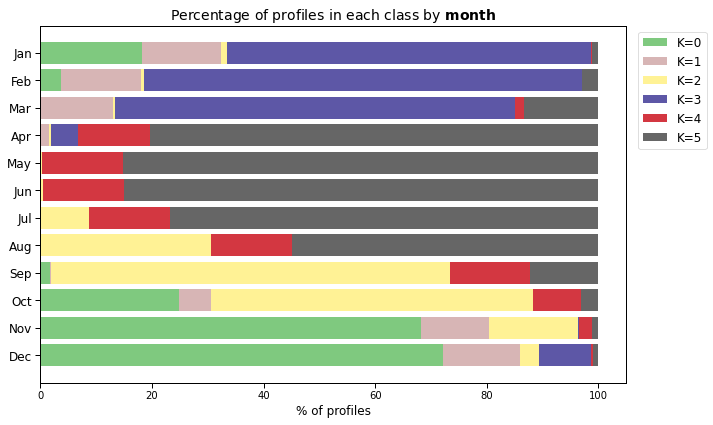

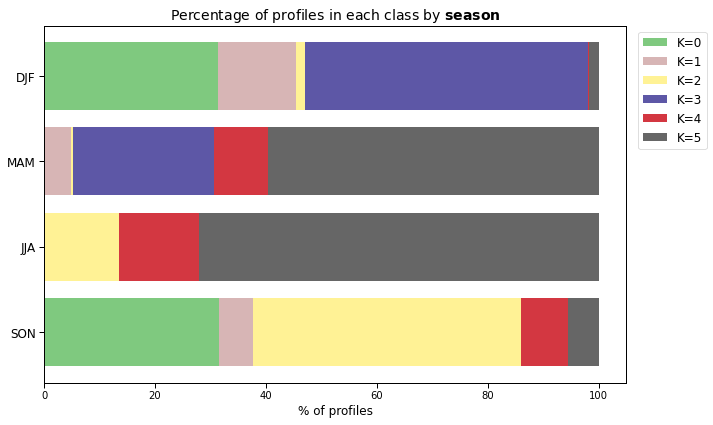

In [26]:
%%time
# name_ext = '_trainsize' + str(train_size)
# name_ext = '_full2'
start_time = time.time()
generate_plots(ds=ds, var_name_ds=var_name_ds, k=k, algorithm=algorithm)
plot_time = time.time() - start_time
print("plot finished in " + str(plot_time) + "sec")

plot finished in 23.802247047424316sec
CPU times: user 12.7 s, sys: 9.37 s, total: 22.1 s
Wall time: 23.8 s


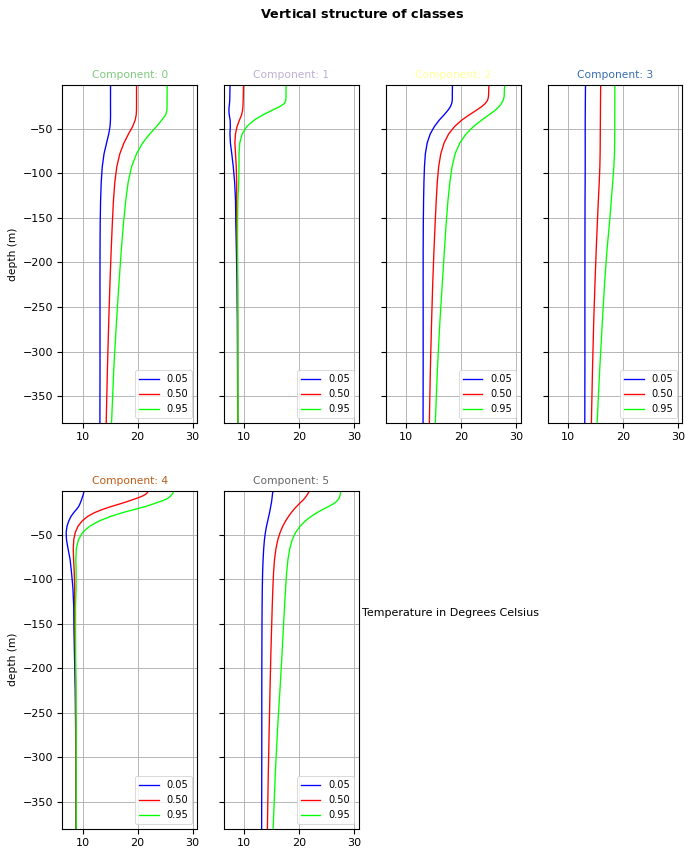

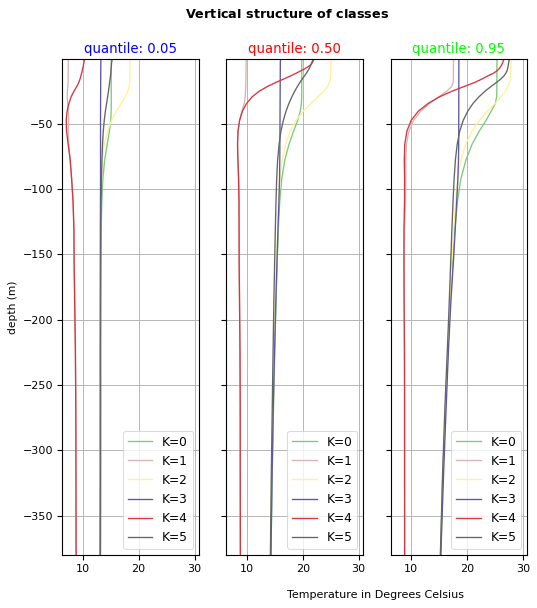

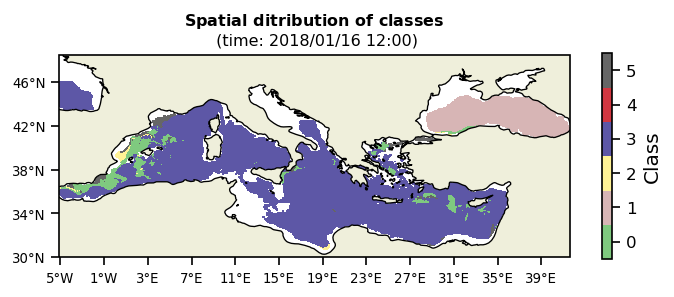

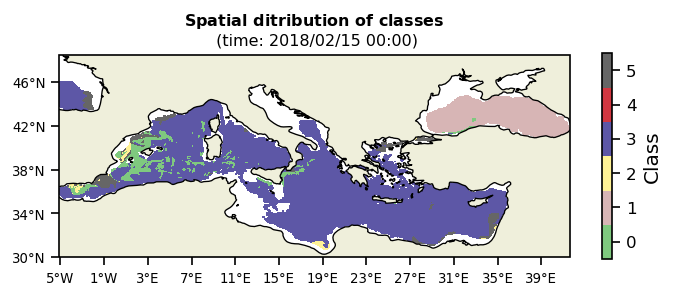

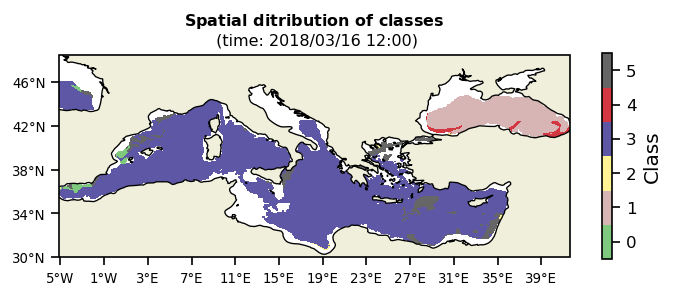

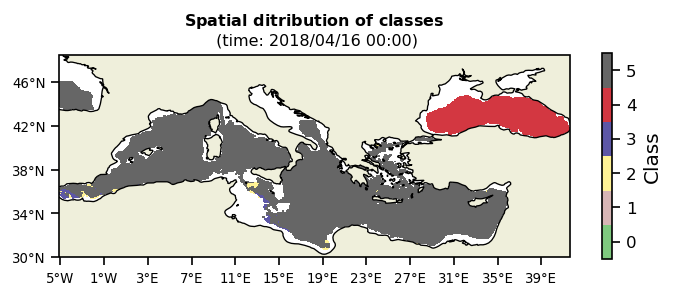

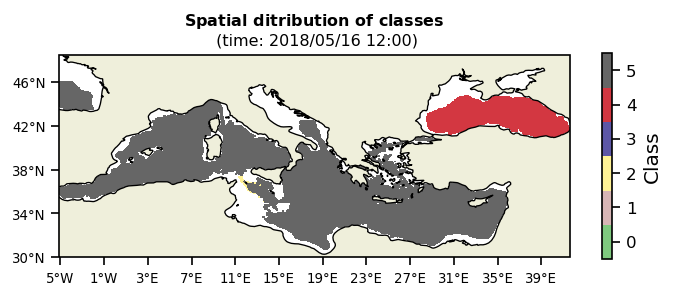

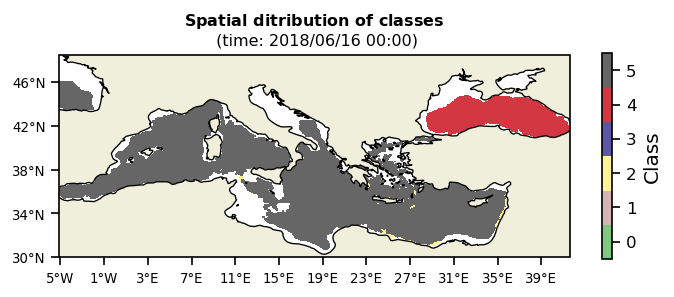

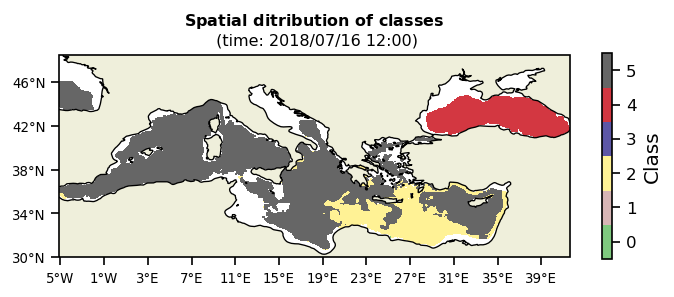

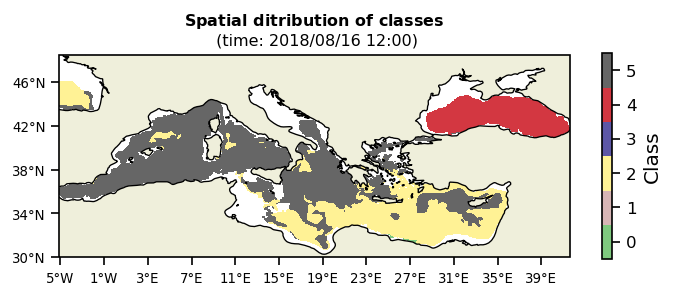

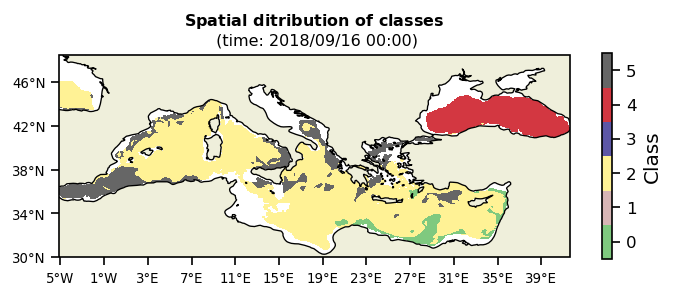

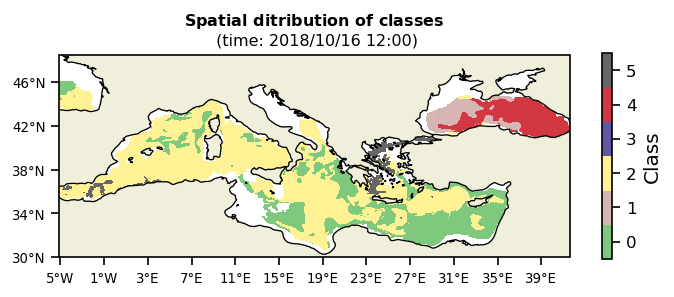

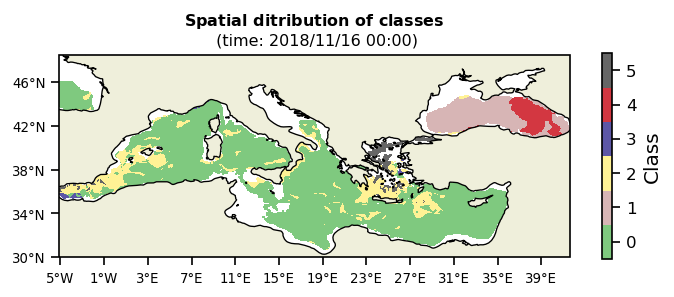

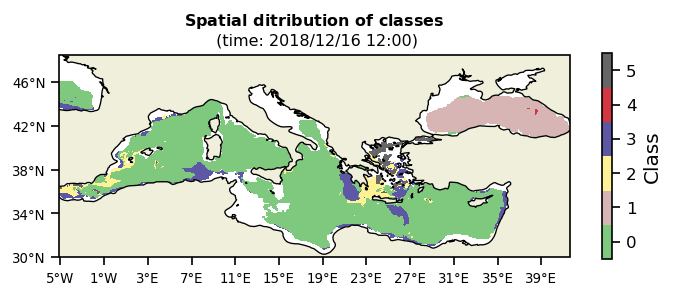

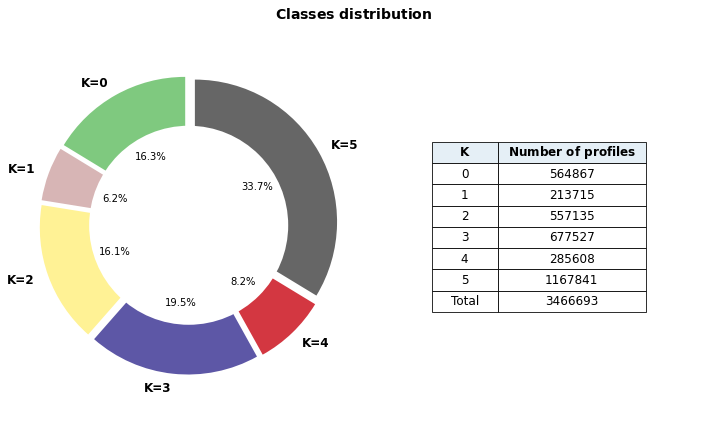

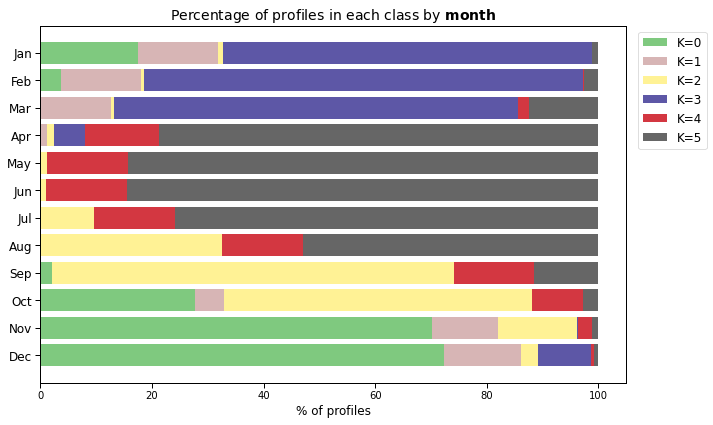

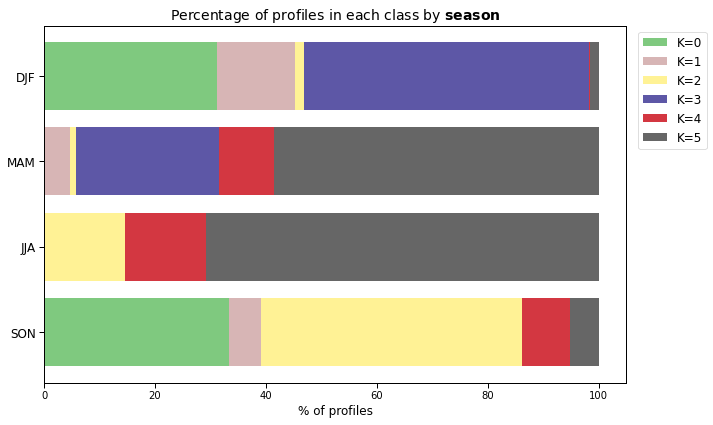

In [29]:
%%time
# name_ext = '_trainsize' + str(train_size)
# name_ext = '_full2'
start_time = time.time()
generate_plots(ds=ds_full, var_name_ds=var_name_ds, k=k, algorithm=algorithm)
plot_time = time.time() - start_time
print("plot finished in " + str(plot_time) + "sec")